In [1]:
import os
import pydicom
from PIL import Image
import numpy as np
import tensorflow as tf
import logging
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization



logging.basicConfig(level=logging.INFO)


In [2]:
""" import pydicom
import numpy as np
import logging
from PIL import Image
import tensorflow as tf

def load_dicom_image(path, img_size=256, use_rgb=False):
    try:
        dicom = pydicom.dcmread(path)
        image = dicom.pixel_array

        if use_rgb:
            # Convert to RGB if needed (some models may require 3 channels)
            image = np.stack([image] * 3, axis=-1)

        image = Image.fromarray(image)
        image = image.resize((img_size, img_size))
        image = np.array(image) / 255.0  # Normalize the image

        # Assert to ensure all values are between 0 and 1
        assert np.all((image >= 0) & (image <= 1)), "Image values should be in the range [0, 1]"

        return tf.convert_to_tensor(image, dtype=tf.float32)
    except Exception as e:
        logging.error(f"Failed to process image {path}: {e}")
        return None """


In [2]:
import pydicom
import numpy as np
import logging
from PIL import Image
import tensorflow as tf

def load_dicom_image(path, img_size=256, use_rgb=False):
    try:
        dicom = pydicom.dcmread(path)
        image = dicom.pixel_array

        # Adjusting normalization based on the actual range of the pixel data
        max_pixel_value = np.max(image)
        if max_pixel_value > 0:  # Prevent division by zero
            image = image / max_pixel_value  # Normalize the image

        if use_rgb:
            # Convert to RGB if needed (some models may require 3 channels)
            image = np.stack([image] * 3, axis=-1)

        image = Image.fromarray((image * 255).astype(np.uint8))  # Scale to 0-255 to use PIL
        image = image.resize((img_size, img_size))
        image = np.array(image) / 255.0  # Normalize the image back to 0-1

        # Assert to ensure all values are between 0 and 1
        assert np.all((image >= 0) & (image <= 1)), "Image values should be in the range [0, 1]"

        return tf.convert_to_tensor(image, dtype=tf.float32)
    except Exception as e:
        logging.error(f"Failed to process image {path}: {e}")
        return None


In [3]:
def process_patient_images(patient_folder, img_size=256):
    images = []
    try:
        for filename in os.listdir(patient_folder):
            if filename.endswith('.dcm'):
                path = os.path.join(patient_folder, filename)
                image = load_dicom_image(path, img_size=img_size)
                if image is not None:
                    images.append(image)
    except Exception as e:
        logging.warning(f"Error processing folder {patient_folder}: {e}")
    return images

In [4]:
import os

def collect_images_and_labels(root_dir, img_size=256):
    all_images = []
    all_labels = []
    conditions = {'cancer': 1, 'non_cancer': 0}  # Update as per your folder names

    def process_directory(directory, label):
        # Traverse the directory recursively
        for entry in os.listdir(directory):
            path = os.path.join(directory, entry)
            if os.path.isdir(path):
                process_directory(path, label)  # Recursive call for subdirectories
            elif entry.endswith('.dcm'):
                # Process this file if it's a DICOM file (assuming flat structure inside final folders)
                image = load_dicom_image(path, img_size)
                if image is not None:
                    all_images.append(image)
                    all_labels.append(label)

    for condition, label in conditions.items():
        condition_path = os.path.join(root_dir, condition)
        if os.path.isdir(condition_path):
            process_directory(condition_path, label)  # Start the recursive processing

    return all_images, all_labels


In [5]:
# Example of how to use the collect_images_and_labels
root_dir = '/Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/new_train_data'
images, labels = collect_images_and_labels(root_dir)

2024-04-19 19:39:37.231085: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-04-19 19:39:37.231116: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2024-04-19 19:39:37.231122: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2024-04-19 19:39:37.231140: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-19 19:39:37.231155: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
import numpy as np

print("Images shape:", np.array(images).shape)
print("Labels shape:", np.array(labels).shape)

Images shape: (14527, 256, 256)
Labels shape: (14527,)


In [10]:
""" images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)
images_train_tensor = tf.convert_to_tensor(images_train)
images_test_tensor = tf.convert_to_tensor(images_test)
images_train_tensor_1 = images_train_tensor[:10] """

In [6]:
images_train = tf.convert_to_tensor(images)
images_train.shape

TensorShape([14527, 256, 256])

In [13]:
# Make it more Conv2d, 32, 64, 128
# And in reverse for transpose 128, 64, 32
# Use Batch Normalization for Each Conv2D Layer

class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(256, 256, 1)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
      BatchNormalization(),
      layers.Flatten(),
      layers.Dense(10000, activation='relu'),
      layers.Dense(5000, activation='relu'),
      layers.Dense(latent_dim, activation='linear'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(5000, activation='relu'),
      layers.Dense(10000, activation='relu'),
      layers.Dense(32*32*128, activation='relu'),
      layers.Reshape((32,32,128)),
      layers.Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = images_train.shape[1:]
latent_dim = 500
autoencoder = Autoencoder(latent_dim, shape)

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [16]:
history = autoencoder.fit(images_train, images_train,
                epochs=10,
                shuffle=True,
                batch_size=64)

Epoch 1/10
  1/227 ━━━━━━━━━━━━━━━━━━━━ 1:26:37 23s/step - loss: 0.1317

In [11]:
encoded_imgs = autoencoder.encoder(images_train[:10]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [32]:
assert decoded_imgs[0][0] != decoded_imgs[1][0],"Shape should be different"
# print(decoded_imgs[0]*255)
# print(decoded_imgs[1]*255)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [26]:
print(encoded_imgs[0]*255)
print(encoded_imgs[1]*255)

[ 2.73259114e-02  1.27801206e-02  7.42050111e-01  1.68778807e-01
  7.30708838e-01  2.24310607e-02  2.69082934e-01 -1.12955265e-01
  1.66302517e-01  6.27868474e-02  7.92826712e-03  1.94154024e-01
  3.64654958e-02 -1.66107699e-01  9.49869812e-01  2.16487718e+00
 -1.14610270e-02 -6.04243539e-02  3.47831666e-01 -1.11538923e+00
  3.59534137e-02 -1.14779375e-01  1.55218408e-01 -6.78749979e-01
  9.83411908e-01 -1.52001053e-01  2.96420958e-02 -1.06826447e-01
 -1.72060847e-01 -2.52048969e-01 -5.42467654e-01  3.30064386e-01
  1.94859907e-01 -5.44662178e-01 -1.05426386e-01 -4.02476043e-02
 -6.08092733e-03  9.60098058e-02  8.87614582e-03  5.91355711e-02
 -2.21083760e-01  1.14462808e-01  1.78734988e-01  5.94971105e-02
 -3.58649939e-01  7.30002597e-02  9.50524509e-02 -2.60751434e-02
  8.65079984e-02 -4.69902337e-01  9.31450650e-02  1.03449702e+00
 -1.21728189e-01  4.50771004e-02  1.16386741e-01 -2.13816360e-01
 -3.61942425e-02  1.24244049e-01  2.20352691e-02  8.74618068e-02
 -4.99419838e-01  3.18039

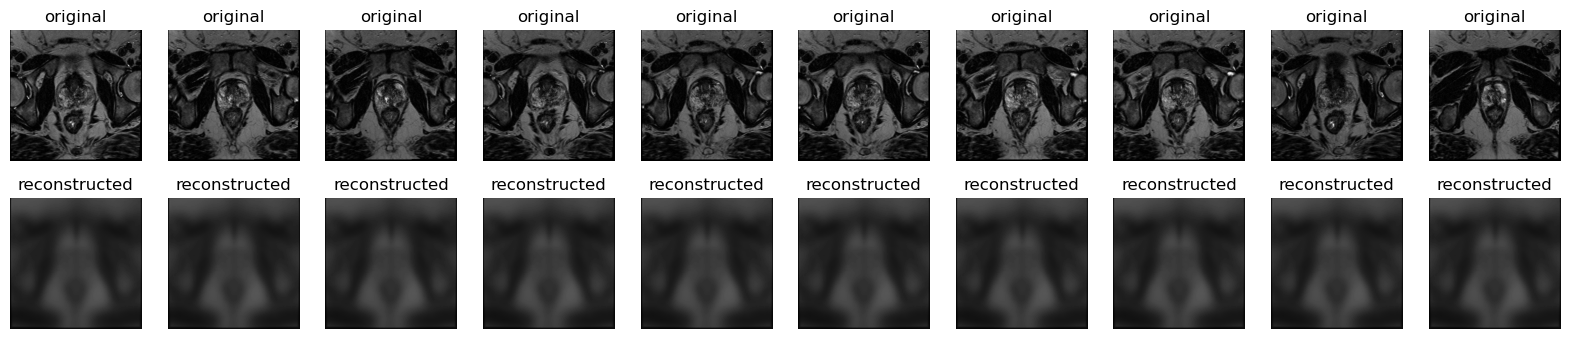

In [12]:
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images_train[i].numpy() * 255, cmap='gray', vmin=0, vmax=255)
    plt.title("original")
    plt.axis('off')  # Hide axes for clarity

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i] * 255, cmap='gray', vmin=0, vmax=255)
    plt.title("reconstructed")
    plt.axis('off')
plt.show()


In [25]:
import pandas as pd

# Load labels into dataframe 

latent_representations = pd.DataFrame(autoencoder.encoder.predict(images_train))  # Generate latent representations
latent_representations['labels'] = labels


# Save the latent representations
latent_representations.to_csv('latent_representations.csv', index=False)


454/454 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


In [26]:
latent_representations

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,labels
0,0.00349,-0.003468,-0.004726,-0.000243,0.000437,0.001415,-0.001481,0.00325,-0.003815,0.000048,...,0.002192,-0.000736,-0.001807,0.00028,0.00418,0.000228,0.001122,0.001464,0.001089,1
1,0.00349,-0.003468,-0.004726,-0.000243,0.000437,0.001415,-0.001481,0.00325,-0.003815,0.000048,...,0.002192,-0.000736,-0.001807,0.00028,0.00418,0.000228,0.001122,0.001464,0.001089,1
2,0.00349,-0.003468,-0.004726,-0.000243,0.000437,0.001415,-0.001481,0.00325,-0.003815,0.000048,...,0.002192,-0.000736,-0.001807,0.00028,0.00418,0.000228,0.001122,0.001464,0.001089,1
3,0.00349,-0.003468,-0.004726,-0.000243,0.000437,0.001415,-0.001481,0.00325,-0.003815,0.000048,...,0.002192,-0.000736,-0.001807,0.00028,0.00418,0.000228,0.001122,0.001464,0.001089,1
4,0.00349,-0.003468,-0.004726,-0.000243,0.000437,0.001415,-0.001481,0.00325,-0.003815,0.000048,...,0.002192,-0.000736,-0.001807,0.00028,0.00418,0.000228,0.001122,0.001464,0.001089,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14522,0.00349,-0.003468,-0.004726,-0.000243,0.000437,0.001415,-0.001481,0.00325,-0.003815,0.000048,...,0.002192,-0.000736,-0.001807,0.00028,0.00418,0.000228,0.001122,0.001464,0.001089,0
14523,0.00349,-0.003468,-0.004726,-0.000243,0.000437,0.001415,-0.001481,0.00325,-0.003815,0.000048,...,0.002192,-0.000736,-0.001807,0.00028,0.00418,0.000228,0.001122,0.001464,0.001089,0
14524,0.00349,-0.003468,-0.004726,-0.000243,0.000437,0.001415,-0.001481,0.00325,-0.003815,0.000048,...,0.002192,-0.000736,-0.001807,0.00028,0.00418,0.000228,0.001122,0.001464,0.001089,0
14525,0.00349,-0.003468,-0.004726,-0.000243,0.000437,0.001415,-0.001481,0.00325,-0.003815,0.000048,...,0.002192,-0.000736,-0.001807,0.00028,0.00418,0.000228,0.001122,0.001464,0.001089,0


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model

# Load latent representations
latent_representations = np.load('latent_representations.npy')

# Define a new model that uses the latent representations
input_latent = Input(shape=(500,))
x = Dense(64, activation='relu')(input_latent)
output = Dense(1, activation='sigmoid')(x)  
model = Model(input_latent, output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

